# PS reconstruction, Gaussian beam

In [1]:
import numpy as np
import torch
import lightning as L

from gpsr.datasets import SixDReconstructionDataset, split_dataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Import data

torch.Size([10, 2, 3]) torch.Size([5, 2, 2, 3]) torch.Size([10, 200, 200]) torch.Size([5, 2, 200, 200]) <class 'cheetah.accelerator.screen.Screen'>


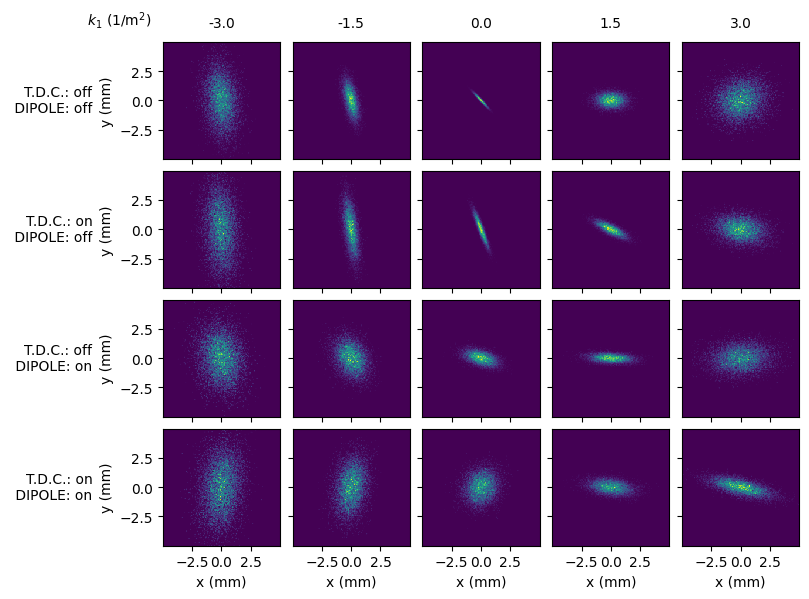

In [2]:
dset = torch.load(
    "example_data/example_datasets/reconstruction_6D.dset", weights_only=False
)

print(
    dset.parameters.shape,
    dset.six_d_parameters.shape,
    dset.observations[0].shape,
    dset.six_d_observations[0].shape,
    type(dset.screens[0]),
)

dset.plot_data(publication_size=True);

In [3]:
train_k_ids = np.arange(0, len(dset.six_d_parameters), 2)
train_dset, test_dset = split_dataset(dset, train_k_ids)

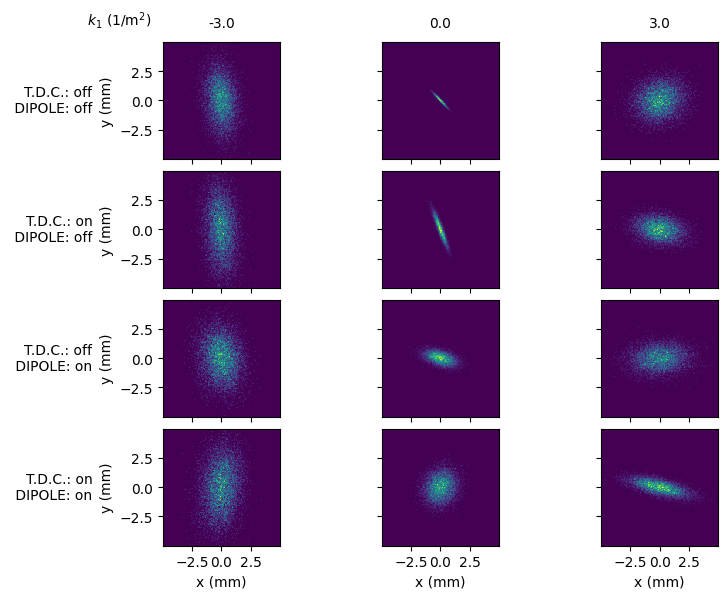

In [4]:
train_dset.plot_data(publication_size=True);

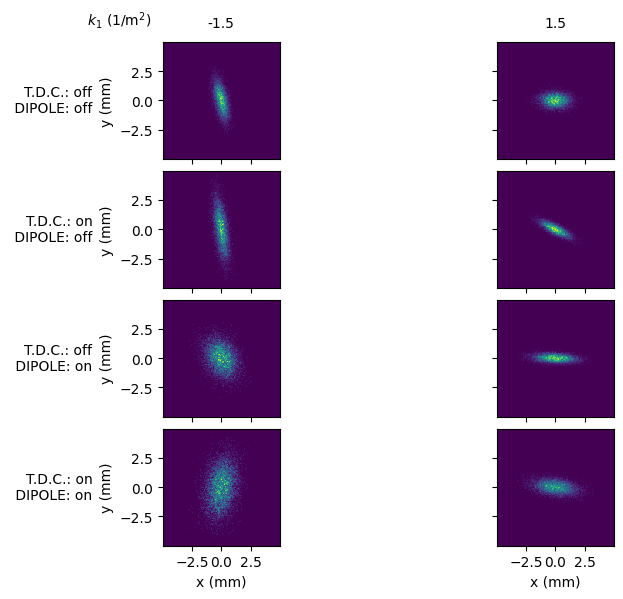

In [5]:
test_dset.plot_data(publication_size=True);

## Set up diagnostic lattice in cheetah
These parameters match those at the Argonne Wakefield Accelerator (AWA) and were used
 to generate the synthetic example dataset.

In [6]:
p0c = 43.36e6  # reference momentum in eV/c

screens = train_dset.screens

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889

gpsr_lattice = GPSR6DLattice(
    l_quad, l_tdc, f_tdc, phi_tdc, l_bend, theta_on, l1, l2, l3, *screens
)

## Training using pytorch lightning

In [7]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
/Users/pablo/miniforge3/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve perfor

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s, v_num=27]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, v_num=27]


In [8]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

In [9]:
reconstructed_beam

ParticleBeam(particles=tensor([[-6.3547e-05, -4.2024e-06, -8.8090e-04,  ..., -1.7118e-04,
          7.5941e-04,  1.0000e+00],
        [-1.6918e-03,  7.1953e-04, -1.4100e-04,  ..., -2.2095e-06,
         -1.2220e-03,  1.0000e+00],
        [ 1.7506e-03, -9.3371e-04, -1.8542e-03,  ..., -2.3227e-04,
         -5.9363e-04,  1.0000e+00],
        ...,
        [-1.6211e-04,  4.1066e-05, -3.4061e-04,  ...,  2.2437e-06,
          5.2620e-04,  1.0000e+00],
        [ 1.7702e-04,  2.7304e-05,  1.0988e-03,  ...,  2.4620e-04,
          4.4839e-03,  1.0000e+00],
        [-3.4187e-05,  1.6617e-05,  9.2871e-04,  ...,  7.2591e-05,
          2.0472e-03,  1.0000e+00]], grad_fn=<CopySlices>), energy=43363012.0, particle_charges=1.0, survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), s=0.0, species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

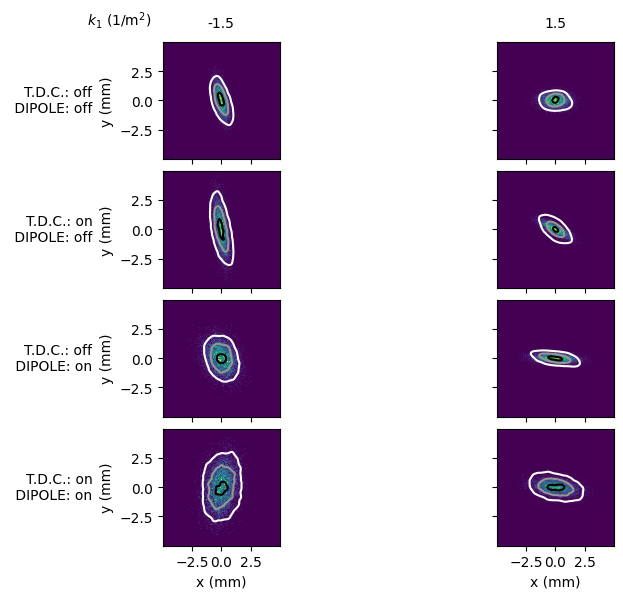

In [10]:
test_params = test_dset.six_d_parameters
pred = tuple([ele.detach() for ele in gpsr_model(test_params)])
pred_dset = SixDReconstructionDataset(test_params, pred, test_dset.screens)
test_dset.plot_data(
    publication_size=True,
    overlay_data=pred_dset,
    overlay_kwargs={"cmap": "Greys", "levels": [0.1, 0.5, 0.9]},
);

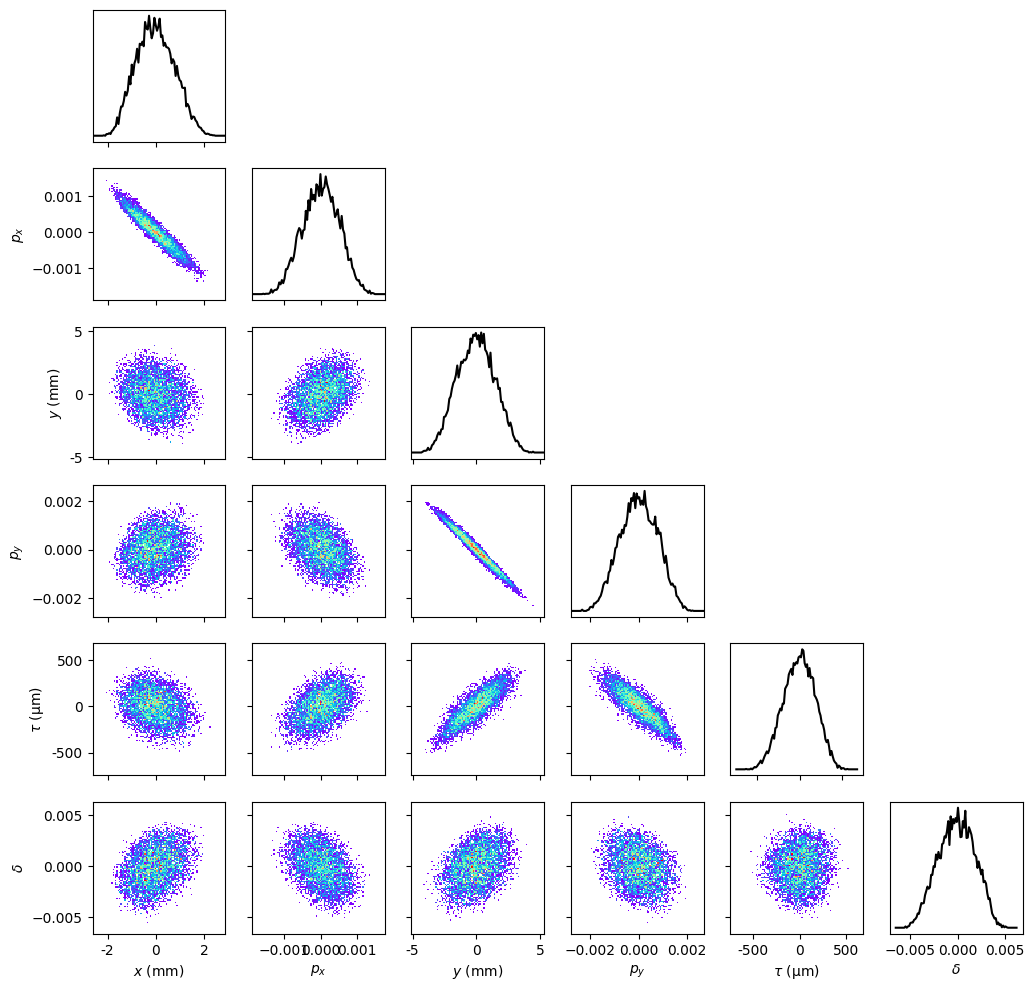

In [11]:
reconstructed_beam.plot_distribution();